In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import pickle
import requests

In [ ]:
# Load dataset
df = pd.read_csv('dataset.csv')

# Melihat statistik dasar
print(df.describe())
print(df.info())

       Soil_Moisture  Temperature  Air_Humidity    Pump_Data
count    3000.000000  3000.000000   3000.000000  3000.000000
mean      662.419754    28.443043     59.387209     0.523000
std       187.936297     6.018565     12.428161     0.499554
min       314.511016    18.002132     38.000201     0.000000
25%       501.362575    23.320750     48.661993     0.000000
50%       666.578554    28.361854     58.975423     1.000000
75%       821.867423    33.595989     70.138397     1.000000
max       984.828010    38.992770     81.267407     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Soil_Moisture  3000 non-null   float64
 1   Temperature    3000 non-null   float64
 2   Air_Humidity   3000 non-null   float64
 3   Pump_Data      3000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 93.9 KB
None


In [ ]:
# Hitung jumlah masing-masing nilai di kolom Pump_Data
pump_counts = df['Pump_Data'].value_counts()
print("Jumlah Pump_Data = 1:", pump_counts.get(1, 0))
print("Jumlah Pump_Data = 0:", pump_counts.get(0, 0))
print("Jumlah duplikasi:", df.duplicated().sum())

Jumlah Pump_Data = 1: 1569
Jumlah Pump_Data = 0: 1431
Jumlah duplikasi: 0


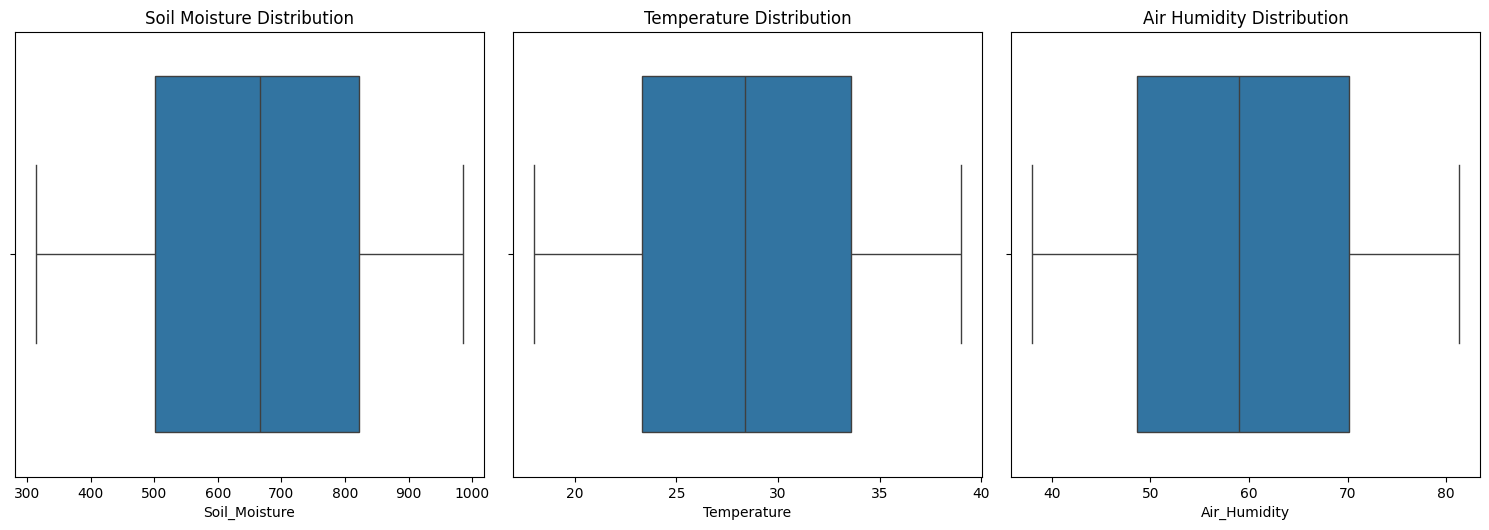

In [ ]:
# Visualisasi data asli
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(x=df["Soil_Moisture"])
plt.title('Soil Moisture Distribution')

plt.subplot(2, 3, 2)
sns.boxplot(x=df["Temperature"])
plt.title('Temperature Distribution')

plt.subplot(2, 3, 3)
sns.boxplot(x=df["Air_Humidity"])
plt.title('Air Humidity Distribution')

plt.tight_layout()
plt.show()

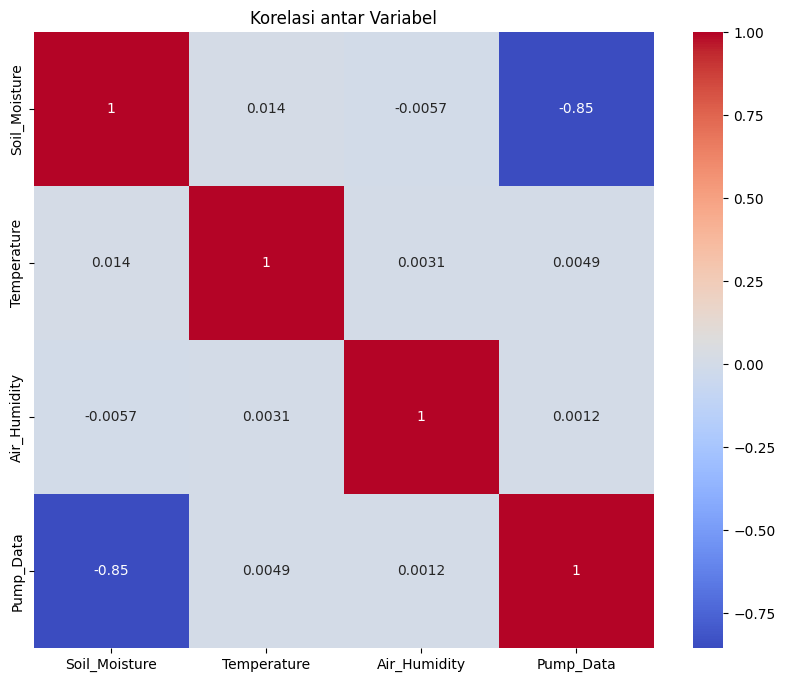

In [ ]:
# Memeriksa korelasi antar variabel
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Variabel')
plt.show()

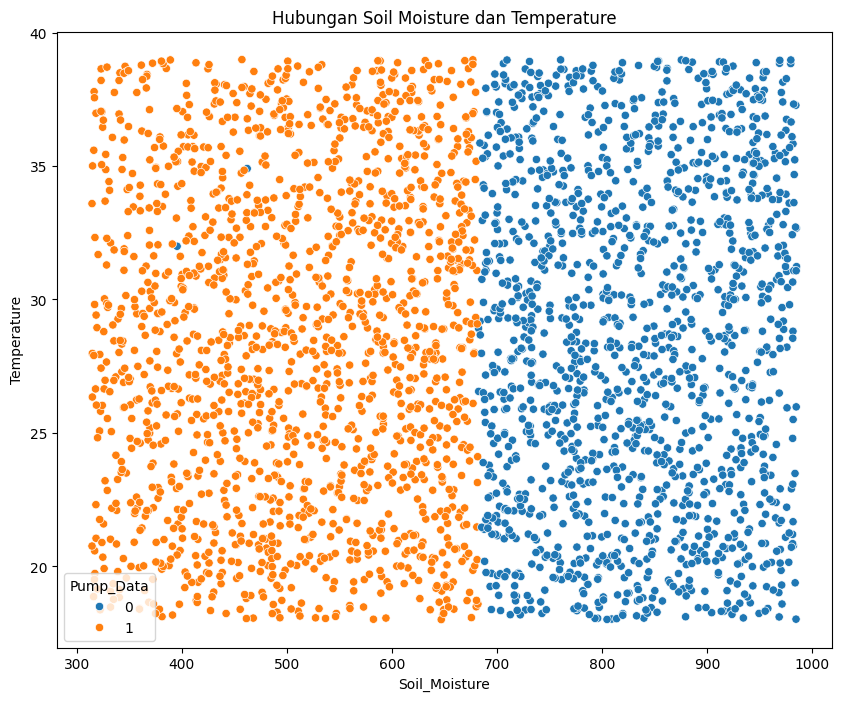

In [ ]:
# Visualisasi scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Soil_Moisture', y='Temperature', hue='Pump_Data')
plt.title('Hubungan Soil Moisture dan Temperature')
plt.show()

In [ ]:
#Data yang tidak perlu siram (label 0)
tidak_siram_df = df[df['Pump_Data'] == 0].copy()
tidak_siram_df['Irrigation_Level'] = 0

In [ ]:
#Data yang perlu di siram (menjadi 3 level)
siram_df = df[df['Pump_Data'] == 1].copy()

In [ ]:
print(f"Data tidak siram: {len(tidak_siram_df)}")
print(f"Data perlu siram: {len(siram_df)}")

Data tidak siram: 1431
Data perlu siram: 1569


Distribusi Irrigation_Level:
Irrigation_Level
0    1431
1     486
2     549
3     534
Name: count, dtype: int64


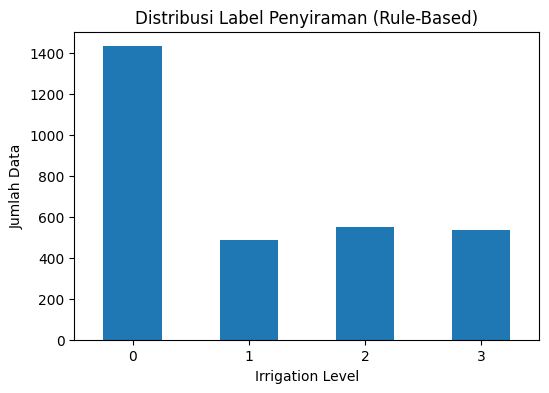

In [ ]:
def assign_irrigation_level(row):
    sm = row['Soil_Moisture']
    temp = row['Temperature']
    hum = row['Air_Humidity']

    # Jika tidak perlu disiram dari Pump_Data
    if row['Pump_Data'] == 0:
        return 0

    # Aturan berdasarkan Soil Moisture dominan dan didukung Temp & Humidity
    if sm < 450 or (sm < 500 and temp > 32 and hum < 55):
        return 3  # Siram Banyak
    elif sm < 550 or (temp > 30 and hum < 60):
        return 2  # Siram Sedang
    else:
        return 1  # Siram Sedikit


df['Irrigation_Level'] = df.apply(assign_irrigation_level, axis=1)

# Tampilkan distribusi
print("Distribusi Irrigation_Level:")
print(df['Irrigation_Level'].value_counts().sort_index())

# Opsional: visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df['Irrigation_Level'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribusi Label Penyiraman (Rule-Based)")
plt.xlabel("Irrigation Level")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Gabungkan dataset
final_df = df

In [ ]:
# ANALISIS DATASET FINAL
print("Distribusi Irrigation Level:")
print(final_df['Irrigation_Level'].value_counts().sort_index())

Distribusi Irrigation Level:
Irrigation_Level
0    1431
1     486
2     549
3     534
Name: count, dtype: int64


In [ ]:
irrigation_labels = {0: 'Tidak Siram', 1: 'Siram Sedikit', 2: 'Siram Sedang', 3: 'Siram Banyak'}
for level, count in final_df['Irrigation_Level'].value_counts().sort_index().items():
    print(f"Level {level} ({irrigation_labels[level]}): {count}")

Level 0 (Tidak Siram): 1431
Level 1 (Siram Sedikit): 486
Level 2 (Siram Sedang): 549
Level 3 (Siram Banyak): 534


In [ ]:
print(f"\nTotal data: {len(final_df)}")
print(final_df.head(10))


Total data: 3000
   Soil_Moisture  Temperature  Air_Humidity  Pump_Data  Irrigation_Level
0     683.802906    29.184908     71.789699          0                 0
1     408.571567    33.707205     77.977391          1                 3
2     659.092074    24.760311     60.776282          1                 1
3     842.929764    32.738515     59.323543          0                 0
4     414.199320    25.692744     66.624914          1                 3
5     487.521226    33.806809     47.774693          1                 3
6     820.856733    32.659495     40.317592          0                 0
7     726.504807    38.083939     50.915951          0                 0
8     939.915978    35.430747     60.822721          0                 0
9     628.397718    34.232923     42.994402          1                 2


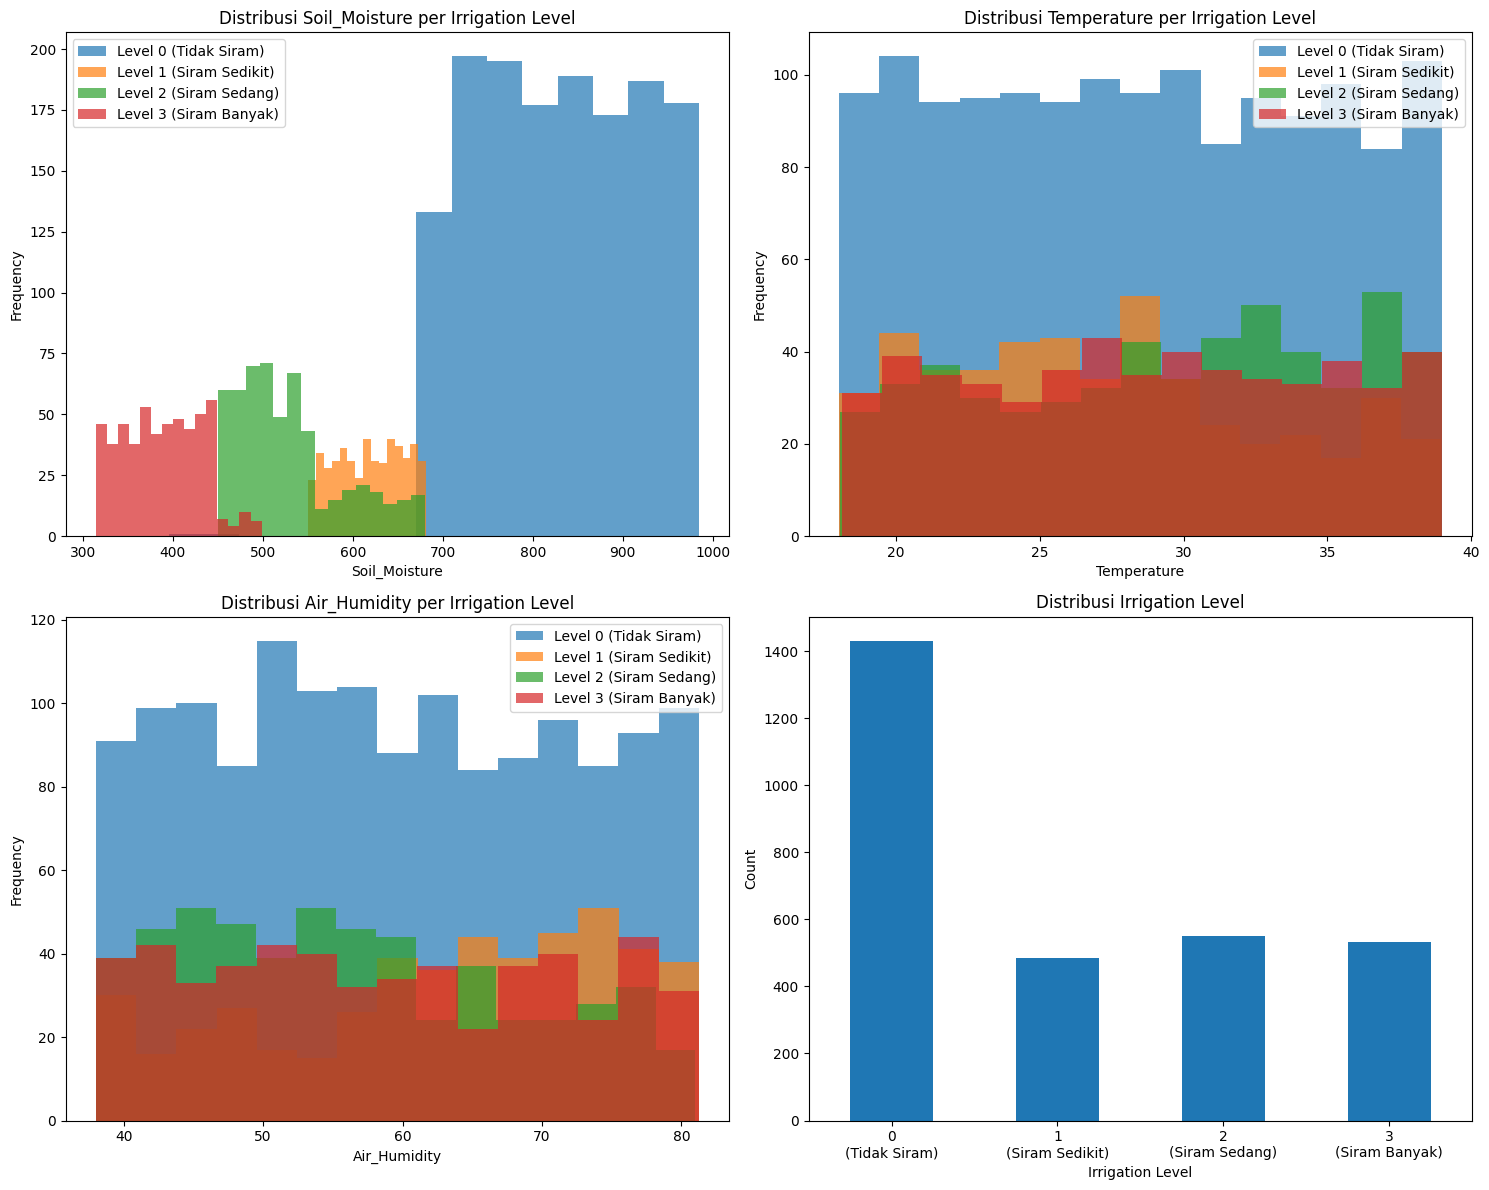

In [ ]:
# Visualisasi distribusi per kelas
plt.figure(figsize=(15, 12))

for i, feature in enumerate(['Soil_Moisture', 'Temperature', 'Air_Humidity']):
    plt.subplot(2, 2, i+1)
    for level in sorted(final_df['Irrigation_Level'].unique()):
        data = final_df[final_df['Irrigation_Level'] == level][feature]
        plt.hist(data, alpha=0.7, label=f'Level {level} ({irrigation_labels[level]})', bins=15)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribusi {feature} per Irrigation Level')
    plt.legend()

plt.subplot(2, 2, 4)
final_df['Irrigation_Level'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribusi Irrigation Level')
plt.xlabel('Irrigation Level')
plt.ylabel('Count')
plt.xticks(range(4), [f'{i}\n({irrigation_labels[i]})' for i in range(4)], rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Fungsi untuk membuat data sintetis dengan label tertentu
def generate_data(jumlah, level):
    np.random.seed(level)  # supaya hasil bisa direproduksi
    if level == 1:
        return pd.DataFrame({
            'Soil_Moisture': np.random.randint(550, 680, jumlah),
            'Temperature': np.random.uniform(25, 36, jumlah),
            'Air_Humidity': np.random.uniform(45, 65, jumlah),
            'Irrigation_Level': level
        })
    elif level == 2:
        return pd.DataFrame({
            'Soil_Moisture': np.random.randint(450, 550, jumlah),
            'Temperature': np.random.uniform(23, 34, jumlah),
            'Air_Humidity': np.random.uniform(50, 70, jumlah),
            'Irrigation_Level': level
        })
    elif level == 3:
        return pd.DataFrame({
            'Soil_Moisture': np.random.randint(350, 460, jumlah),
            'Temperature': np.random.uniform(22, 32, jumlah),
            'Air_Humidity': np.random.uniform(55, 75, jumlah),
            'Irrigation_Level': level
        })

# Buat data tambahan
data1 = generate_data(945, 1)
data2 = generate_data(882, 2)
data3 = generate_data(897, 3)

# Gabungkan ke dataset awal
df_sintetis = pd.concat([data1, data2, data3], ignore_index=True)

# Gabung dengan dataset asli
final_df = pd.concat([final_df, df_sintetis], ignore_index=True)

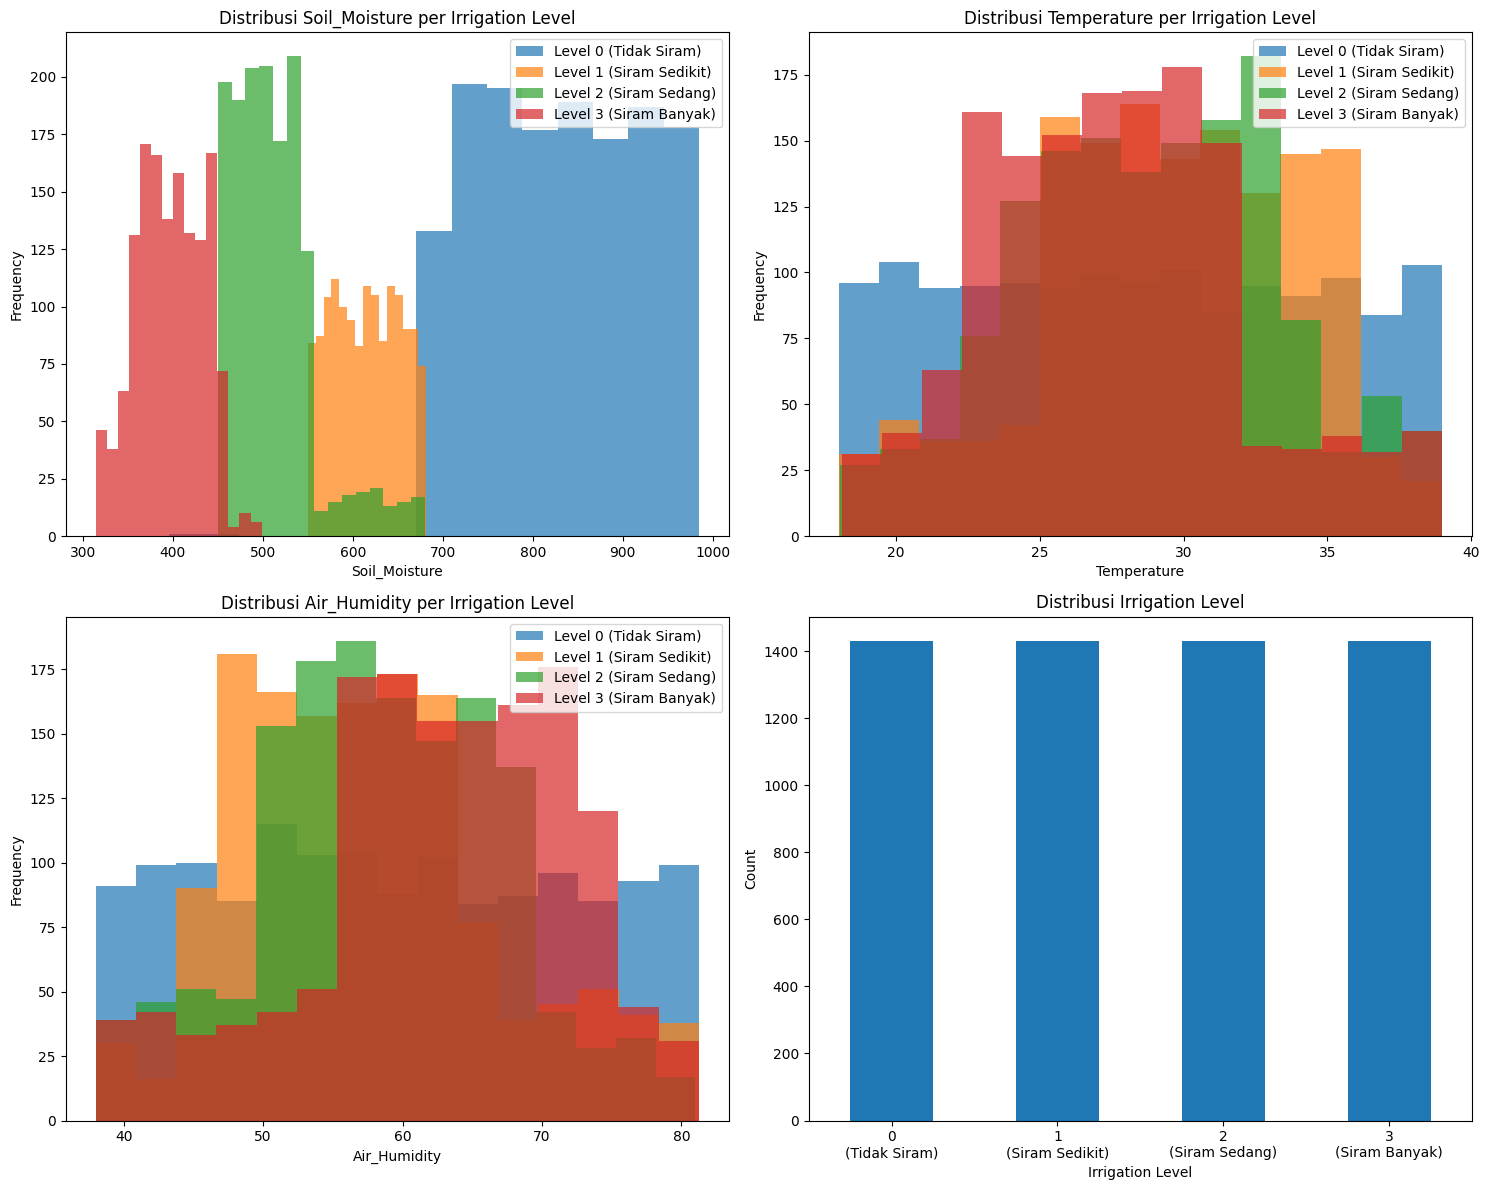

In [ ]:
# Visualisasi distribusi per kelas
plt.figure(figsize=(15, 12))

for i, feature in enumerate(['Soil_Moisture', 'Temperature', 'Air_Humidity']):
    plt.subplot(2, 2, i+1)
    for level in sorted(final_df['Irrigation_Level'].unique()):
        data = final_df[final_df['Irrigation_Level'] == level][feature]
        plt.hist(data, alpha=0.7, label=f'Level {level} ({irrigation_labels[level]})', bins=15)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribusi {feature} per Irrigation Level')
    plt.legend()

plt.subplot(2, 2, 4)
final_df['Irrigation_Level'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribusi Irrigation Level')
plt.xlabel('Irrigation Level')
plt.ylabel('Count')
plt.xticks(range(4), [f'{i}\n({irrigation_labels[i]})' for i in range(4)], rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
final_df.drop(columns=['Pump_Data'], inplace=True)


In [ ]:
print(final_df.columns)


Index(['Soil_Moisture', 'Temperature', 'Air_Humidity', 'Irrigation_Level'], dtype='object')


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Soil_Moisture     5724 non-null   float64
 1   Temperature       5724 non-null   float64
 2   Air_Humidity      5724 non-null   float64
 3   Irrigation_Level  5724 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 179.0 KB


In [ ]:
# Simpan dataset
final_df.to_csv("final_dataset.csv", index=False)

In [ ]:
# PERSIAPAN DATA UNTUK TRAINING
X = final_df[['Soil_Moisture', 'Temperature', 'Air_Humidity']]
y = final_df['Irrigation_Level']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Simpan scaler
with open('scaler_multiclass.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
print(f"\nData training: {X_train_scaled.shape}")
print(f"Data testing: {X_test_scaled.shape}")
print(f"Distribusi y_train:\n{pd.Series(y_train).value_counts().sort_index()}")


Data training: (4580, 3)
Data testing: (1145, 3)
Distribusi y_train:
Irrigation_Level
0    1144
1    1145
2    1145
3    1145
Name: count, dtype: int64


In [ ]:
# BUILD MODEL MULTICLASS
def build_multiclass_irrigation_model(input_shape, num_classes=4):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Dense(32, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dropout(0.3),

        # Hidden layers
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),

        # Output layer - multiclass classification
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
input_dim = X_train_scaled.shape[1]
num_classes = len(final_df['Irrigation_Level'].unique())
irrigation_model = build_multiclass_irrigation_model(input_dim, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# TRAINING MODEL ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_irrigation_multiclass_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
]

In [ ]:
# Latih model
history = irrigation_model.fit(
    X_train_scaled, y_train_res,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
897/916 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5363 - loss: 0.9734
Epoch 1: val_loss improved from inf to 0.34994, saving model to best_irrigation_multiclass_model.keras
916/916 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5392 - loss: 0.9682 - val_accuracy: 0.8974 - val_loss: 0.3499
Epoch 2/100
911/916 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.4459
Epoch 2: val_loss improved from 0.34994 to 0.26292, saving model to best_irrigation_multiclass_model.keras
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8212 - loss: 0.4458 - val_accuracy: 0.9225 - val_loss: 0.2629
Epoch 3/100
914/916 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8460 - loss: 0.3831
Epoch 3: val_loss improved from 0.26292 to 0.22329, saving model to best_irrigation_multiclass_model.keras
916/916 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8460 - loss: 0.3831 - val_accuracy: 0.9236 - val_loss: 0.2233
Epoch 4/100
894/916 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789

In [ ]:
# EVALUASI MODEL
test_results = irrigation_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.1390
Test Loss: 0.1201
Test Accuracy: 0.9502


In [ ]:
# Prediksi dan confusion matrix
y_pred = irrigation_model.predict(X_test_scaled, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\n=== CLASSIFICATION REPORT ===")
num_classes = len(final_df['Irrigation_Level'].unique())
print(classification_report(y_test, y_pred_classes,
                          target_names=[irrigation_labels[i] for i in range(num_classes)]))


=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

  Tidak Siram       0.99      1.00      0.99       287
Siram Sedikit       0.91      0.97      0.94       286
 Siram Sedang       0.93      0.88      0.91       286
 Siram Banyak       0.98      0.94      0.96       286

     accuracy                           0.95      1145
    macro avg       0.95      0.95      0.95      1145
 weighted avg       0.95      0.95      0.95      1145



In [ ]:
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


=== CONFUSION MATRIX ===
[[287   0   0   0]
 [  4 278   4   0]
 [  0  28 253   5]
 [  0   0  16 270]]


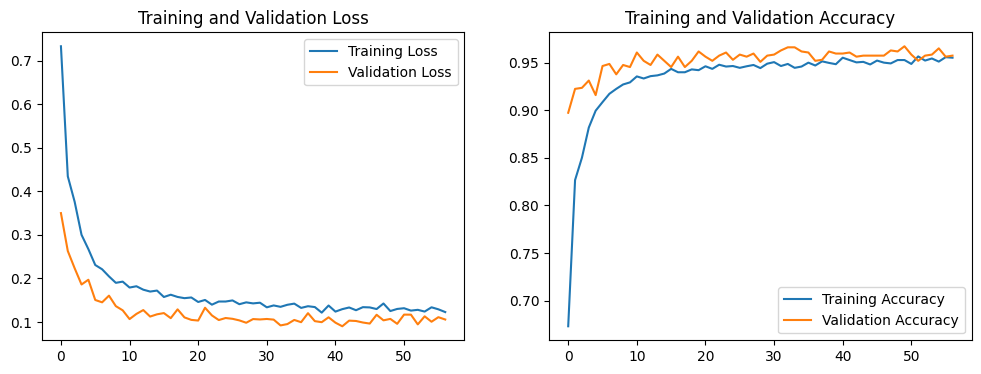

In [ ]:
# Visualisasi hasil training dan confusion matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

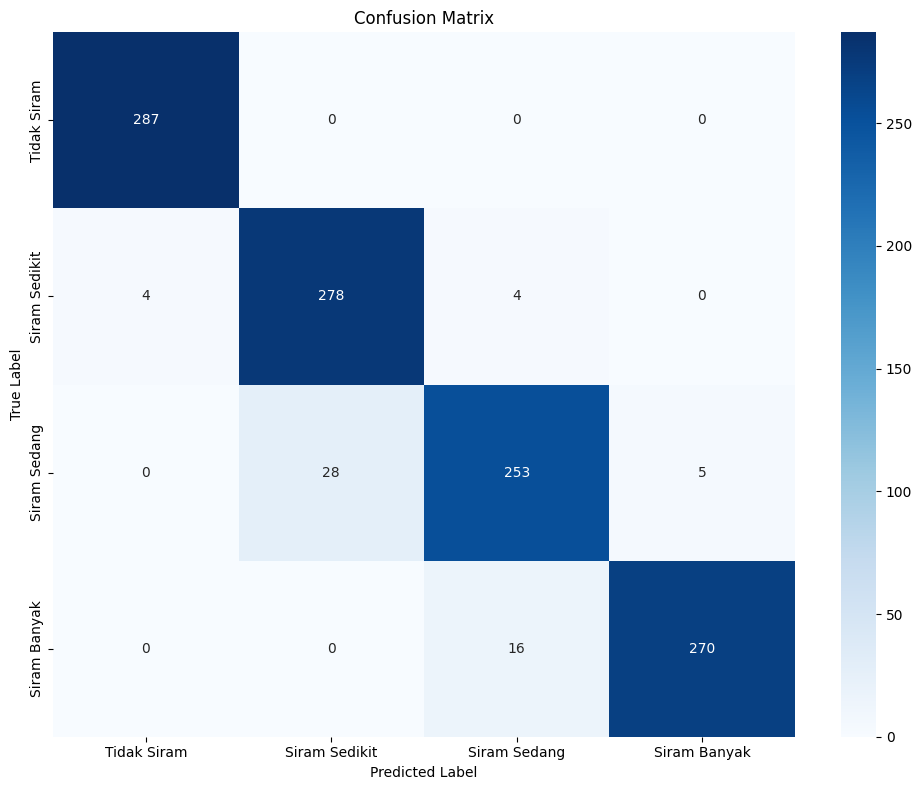

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[irrigation_labels[i] for i in range(num_classes)],
            yticklabels=[irrigation_labels[i] for i in range(num_classes)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()

In [ ]:
# === FUNGSI UNTUK INFERENCE ===
def get_weather_forecast(api_key, location="Malang"):
    """Mendapatkan prediksi cuaca dari Weather API"""
    url = f"https://api.openweathermap.org/data/2.5/forecast?q={location}&appid={api_key}&units=metric"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            forecast = data['list'][0]

            will_rain = False
            rain_amount = 0.0

            if 'weather' in forecast and forecast['weather']:
                weather_condition = forecast['weather'][0]['main'].lower()
                if 'rain' in weather_condition:
                    will_rain = True
                    if 'rain' in forecast and '3h' in forecast['rain']:
                        rain_amount = forecast['rain']['3h']

            return {
                'rain_forecast': 1 if will_rain else 0,
                'rain_amount': rain_amount,
                'api_temperature': forecast['main']['temp'],
                'api_humidity': forecast['main']['humidity']
            }
    except Exception as e:
        print(f"Error fetching weather data: {e}")

    return {
        'rain_forecast': 0,
        'rain_amount': 0.0,
        'api_temperature': None,
        'api_humidity': None
    }

In [ ]:
def calculate_weather_influence_multiclass_improved(weather_data, sensor_data):
    """
    Versi yang diperbaiki dengan pengaruh cuaca yang lebih signifikan
    """
    # Mulai dengan probabilitas netral
    adjustments = np.zeros(4)  # [tidak_siram, siram_sedikit, siram_sedang, siram_banyak]

    # 1. FAKTOR HUJAN - Pengaruh paling kuat
    if weather_data['rain_forecast'] == 1:
        rain_amount = weather_data['rain_amount']

        # Kategorikan intensitas hujan
        if rain_amount >= 5.0:  # Hujan lebat
            # Sangat mengurangi kebutuhan siram
            adjustments[0] += 3.0    # Sangat tingkatkan "tidak siram"
            adjustments[1] -= 1.5    # Kurangi "siram sedikit"
            adjustments[2] -= 2.0    # Kurangi "siram sedang"
            adjustments[3] -= 3.0    # Sangat kurangi "siram banyak"

        elif rain_amount >= 2.0:  # Hujan sedang
            adjustments[0] += 2.0    # Tingkatkan "tidak siram"
            adjustments[1] += 0.5    # Sedikit tingkatkan "siram sedikit"
            adjustments[2] -= 1.0    # Kurangi "siram sedang"
            adjustments[3] -= 2.0    # Kurangi "siram banyak"

        else:  # Hujan ringan (< 2mm)
            adjustments[0] += 1.0    # Tingkatkan "tidak siram"
            adjustments[1] += 0.2    # Sedikit tingkatkan "siram sedikit"
            adjustments[2] -= 0.5    # Sedikit kurangi "siram sedang"
            adjustments[3] -= 1.0    # Kurangi "siram banyak"

    # 2. FAKTOR SUHU - Pengaruh sedang
    if weather_data['api_temperature']:
        temp_sensor = sensor_data['temperature']
        temp_api = weather_data['api_temperature']

        # Jika suhu API lebih tinggi dari sensor (akan lebih panas)
        if temp_api > temp_sensor + 2:  # Perbedaan signifikan
            temp_factor = min((temp_api - temp_sensor) / 5.0, 1.5)
            adjustments[0] -= temp_factor * 0.8
            adjustments[1] -= temp_factor * 0.5
            adjustments[2] += temp_factor * 0.5
            adjustments[3] += temp_factor * 0.8

        # Jika suhu API lebih rendah (akan lebih dingin)
        elif temp_api < temp_sensor - 2:
            temp_factor = min((temp_sensor - temp_api) / 5.0, 1.0)
            adjustments[0] += temp_factor * 0.5
            adjustments[1] += temp_factor * 0.3
            adjustments[2] -= temp_factor * 0.3
            adjustments[3] -= temp_factor * 0.5

    # 3. FAKTOR KELEMBABAN - Pengaruh kecil
    if weather_data['api_humidity']:
        humidity_sensor = sensor_data['humidity']
        humidity_api = weather_data['api_humidity']

        # Jika kelembaban API lebih rendah (lebih kering)
        if humidity_api < humidity_sensor - 10:
            humidity_factor = min((humidity_sensor - humidity_api) / 20.0, 0.8)
            adjustments[0] -= humidity_factor * 0.3
            adjustments[1] -= humidity_factor * 0.2
            adjustments[2] += humidity_factor * 0.2
            adjustments[3] += humidity_factor * 0.3

    return adjustments

In [ ]:
def make_irrigation_decision_improved(sensor_data, weather_data, model, scaler):
    """
    Versi yang diperbaiki dengan threshold yang lebih jelas
    """
    # Persiapkan fitur
    sensor_features = pd.DataFrame({
        'Soil_Moisture': [sensor_data['soil_moisture']],
        'Temperature': [sensor_data['temperature']],
        'Air_Humidity': [sensor_data['humidity']]
    })

    # Normalisasi
    sensor_features_scaled = scaler.transform(sensor_features)

    # Prediksi dasar dari model
    base_prediction = model.predict(sensor_features_scaled, verbose=0)[0]

    # Pengaruh cuaca yang lebih kuat
    weather_adjustments = calculate_weather_influence_multiclass_improved(weather_data, sensor_data)

    # Gabungkan dengan bobot yang lebih besar untuk weather
    adjusted_prediction = base_prediction + weather_adjustments

    # Normalisasi dengan softmax
    adjusted_prediction = np.exp(adjusted_prediction)
    adjusted_prediction = adjusted_prediction / np.sum(adjusted_prediction)

    # Keputusan final dengan threshold
    predicted_class = np.argmax(adjusted_prediction)
    max_confidence = np.max(adjusted_prediction)

    # RULE OVERRIDE: Jika hujan cukup deras dan confidence tidak terlalu tinggi
    if (weather_data['rain_forecast'] == 1 and
        weather_data['rain_amount'] >= 3.0 and
        predicted_class > 0 and
        max_confidence < 0.7):

        # Paksa ke "tidak siram" jika hujan deras
        predicted_class = 0
        override_reason = f"Override: Hujan {weather_data['rain_amount']}mm cukup deras"
    else:
        override_reason = None

    irrigation_labels = {0: 'Tidak Siram', 1: 'Siram Sedikit', 2: 'Siram Sedang', 3: 'Siram Banyak'}

    return {
        'predicted_class': int(predicted_class),
        'decision': irrigation_labels[predicted_class],
        'confidence': float(max_confidence),
        'all_probabilities': {
            irrigation_labels[i]: float(adjusted_prediction[i])
            for i in range(len(adjusted_prediction))
        },
        'base_prediction': {
            irrigation_labels[i]: float(base_prediction[i])
            for i in range(len(base_prediction))
        },
        'weather_adjustments': weather_adjustments,
        'override_reason': override_reason,
        'sensor_data': sensor_data,
        'weather_data': weather_data
    }

In [ ]:
def input_sensor_manual():
    """Input manual dari user"""
    print("\n=== INPUT DATA SENSOR ===")
    soil_moisture = float(input("Masukkan kelembaban tanah (0 - 1023): "))
    temperature = float(input("Masukkan suhu udara sensor (°C): "))
    humidity = float(input("Masukkan kelembaban udara sensor (%): "))
    return {
        "soil_moisture": soil_moisture,
        "temperature": temperature,
        "humidity": humidity
    }


In [ ]:
def get_model_accuracy(model, X_test_scaled, y_test):
    """Mendapatkan akurasi model secara otomatis"""
    test_results = model.evaluate(X_test_scaled, y_test, verbose=0)
    return test_results[1]

In [ ]:
def display_detailed_results(result):
    """Menampilkan hasil dengan tampilan yang lebih sederhana"""
    print("\n" + "="*70)
    print("         HASIL SISTEM IRIGASI (IMPROVED VERSION)")
    print("="*70)

    print(f"📊 Data Sensor:")
    print(f"   • Kelembaban Tanah : {result['sensor_data']['soil_moisture']}")
    print(f"   • Suhu            : {result['sensor_data']['temperature']} °C")
    print(f"   • Kelembaban Udara: {result['sensor_data']['humidity']} %")

    print(f"\n🌤️  Data Cuaca:")
    print(f"   • Prediksi Hujan  : {'Ya' if result['weather_data']['rain_forecast'] else 'Tidak'}")
    if result['weather_data']['rain_amount'] > 0:
        print(f"   • Curah Hujan     : {result['weather_data']['rain_amount']} mm")
    if result['weather_data']['api_temperature']:
        print(f"   • Suhu Cuaca      : {result['weather_data']['api_temperature']} °C")
    if result['weather_data']['api_humidity']:
        print(f"   • Kelembaban Cuaca: {result['weather_data']['api_humidity']} %")

    if result['override_reason']:
        print(f"\n⚠️  {result['override_reason']}")

    print(f"\n🎯 KEPUTUSAN FINAL:")
    decision_icons = {
        "Tidak Siram": "⏸️",
        "Siram Sedikit": "💧",
        "Siram Sedang": "🚿",
        "Siram Banyak": "🌊"
    }
    decision_icon = decision_icons.get(result['decision'], "❓")
    print(f"   {decision_icon} {result['decision'].upper()}")
    print(f"   Confidence: {result['confidence']:.3f} ({result['confidence']*100:.1f}%)")
    print("="*70)

In [ ]:
def display_detailed_results(result):
    """Menampilkan hasil dengan tampilan yang lebih sederhana"""
    print("\n" + "="*70)
    print("         HASIL SISTEM IRIGASI (IMPROVED VERSION)")
    print("="*70)

    print(f"📊 Data Sensor:")
    print(f"   • Kelembaban Tanah : {result['sensor_data']['soil_moisture']}")
    print(f"   • Suhu            : {result['sensor_data']['temperature']} °C")
    print(f"   • Kelembaban Udara: {result['sensor_data']['humidity']} %")

    print(f"\n🌤️  Data Cuaca:")
    print(f"   • Prediksi Hujan  : {'Ya' if result['weather_data']['rain_forecast'] else 'Tidak'}")
    if result['weather_data']['rain_amount'] > 0:
        print(f"   • Curah Hujan     : {result['weather_data']['rain_amount']} mm")
    if result['weather_data']['api_temperature']:
        print(f"   • Suhu Cuaca      : {result['weather_data']['api_temperature']} °C")
    if result['weather_data']['api_humidity']:
        print(f"   • Kelembaban Cuaca: {result['weather_data']['api_humidity']} %")

    if result['override_reason']:
        print(f"\n⚠️  {result['override_reason']}")

    print(f"\n🎯 KEPUTUSAN FINAL:")
    decision_icons = {
        "Tidak Siram": "⏸️",
        "Siram Sedikit": "💧",
        "Siram Sedang": "🚿",
        "Siram Banyak": "🌊"
    }
    decision_icon = decision_icons.get(result['decision'], "❓")
    print(f"   {decision_icon} {result['decision'].upper()}")
    print("="*70)

In [ ]:
if __name__ == "__main__":
    main_inference_improved()

=== SISTEM IRIGASI CERDAS (IMPROVED VERSION) ===

=== INPUT DATA SENSOR ===
Masukkan kelembaban tanah (0 - 1023): 611
Masukkan suhu udara sensor (°C): 30
Masukkan kelembaban udara sensor (%): 77

=== Mengambil data cuaca... ===
=== Loading model... ===


✅ Model berhasil dimuat dengan akurasi: 95.0%

         HASIL SISTEM IRIGASI (IMPROVED VERSION)
📊 Data Sensor:
   • Kelembaban Tanah : 611.0
   • Suhu            : 30.0 °C
   • Kelembaban Udara: 77.0 %

🌤️  Data Cuaca:
   • Prediksi Hujan  : Ya
   • Curah Hujan     : 4.38 mm
   • Suhu Cuaca      : 29.07 °C
   • Kelembaban Cuaca: 94 %

🎯 KEPUTUSAN FINAL:
   ⏸️ TIDAK SIRAM
